In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import extract.compute_gradients as compute_gradients
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
model_type = "binary"

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
input_length = 1000 if model_type == "binary" else 1346
profile_length = 1000

In [4]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_DNase/binary/config/HepG2/HepG2_training_paths.json"
num_tasks = 2
use_controls = True
model_class = binary_models.BinaryPredictor if model_type == "binary" else profile_models.ProfilePredictorWithoutControls
chrom_set = ["chr1"]
dnase_footprint_path = "/users/amtseng/att_priors/data/processed/DNase_footprints/HepG2.bed.gz"
noprior_model_path = "/users/amtseng/att_priors/models/trained_models/binary_models/HepG2_keep1/6/model_ckpt_epoch_4.pt"
prior_model_path = "/users/amtseng/att_priors/models/trained_models/binary_models/HepG2_prior_keep1/9/model_ckpt_epoch_8.pt"

In [5]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
noprior_model = model_util.restore_model(model_class, noprior_model_path)
noprior_model.eval()
noprior_model = noprior_model.to(device) 

In [7]:
prior_model = model_util.restore_model(model_class, prior_model_path)
prior_model.eval()
prior_model = prior_model.to(device) 

### Import set of DNase footprints

In [8]:
footprints = pd.read_csv(
    dnase_footprint_path, sep="\t", header=None,
    names=["chrom", "start", "end", "motifs", "orig_coord"]
)
footprints = footprints[footprints["chrom"].isin(chrom_set)]

### Compute input gradients

In [9]:
noprior_input_grads, noprior_input_seqs, noprior_coords = compute_gradients.get_input_grads(
    noprior_model, model_type, files_spec_path, input_length, reference_fasta,
    chrom_set=chrom_set, profile_length=profile_length,
    use_controls=use_controls, return_coords=True
)

100%|██████████| 606/606 [03:06<00:00,  3.25it/s]


In [10]:
prior_input_grads, prior_input_seqs, prior_coords = compute_gradients.get_input_grads(
    prior_model, model_type, files_spec_path, input_length, reference_fasta,
    chrom_set=chrom_set, profile_length=profile_length,
    use_controls=use_controls, return_coords=True
)

100%|██████████| 606/606 [03:04<00:00,  3.29it/s]


In [11]:
assert np.all(noprior_input_seqs == prior_input_seqs)
assert np.all(noprior_coords == prior_coords)
input_seqs, coords = prior_input_seqs, prior_coords

In [12]:
# Pad the coordinates on both sides symmetrically to make them `input_length` 
centers = (coords[:, 1] + coords[:, 2]) // 2
starts = centers - (input_length // 2)
ends = starts + input_length
coords[:, 1] = starts
coords[:, 2] = ends

### Quantify agreement of gradients with footprints

In [13]:
def score_input(chrom, start, end, grads, footprints):
    """
    From a single coordinate and a list of I x 4 array of actual input gradients
    (i.e. multiplied by input sequence) and the table of footprints, this
    function computes and returns the agreement score, calculated as the
    fraction of gradient magnitudes that fall within a footprint.
    """
    fps = footprints[
        (footprints["chrom"] == chrom) & (footprints["start"] >= start) & \
        (footprints["end"] <= end)
    ]
    mask = np.zeros(end - start, dtype=bool)
    intervals = fps[["start", "end"]].values - start
    for interval in intervals:
        mask[interval[0]:interval[1]] = True
    return [np.sum(grad[mask]) / np.sum(grad) for grad in grads]

In [14]:
noprior_scores, prior_scores = [], []
for i in tqdm.notebook.trange(len(coords)):
    chrom, start, end = coords[i]
    noprior_score, prior_score = score_input(
        chrom, start, end,
        [
            np.abs(noprior_input_grads[i] * input_seqs[i]),
            np.abs(prior_input_grads[i] * input_seqs[i])
        ],
        footprints
    )
    noprior_scores.append(noprior_score)
    prior_scores.append(prior_score)
noprior_scores, prior_scores = np.array(noprior_scores), np.array(prior_scores)

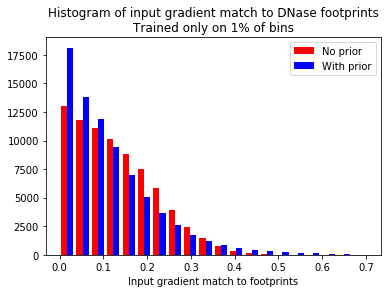

In [17]:
bin_num = 20
plt.figure()
plt.hist(
    [noprior_scores, prior_scores],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of input gradient match to DNase footprints"
title += "\nTrained only on 1% of bins"
plt.title(title)
plt.xlabel("Input gradient match to footprints")
plt.legend()

In [16]:
print("Average score without priors: %f" % np.mean(noprior_scores))
print("Average score with priors: %f" % np.mean(prior_scores))
t, p = scipy.stats.ttest_ind(prior_scores, noprior_scores, equal_var=False)
print("Test of difference of means: t = %f, p = %f" % (t, p / 2))

Average score without priors: 0.128694
Average score with priors: 0.115616
Test of difference of means: t = -26.153869, p = 0.000000
